How to run a stellar evolution code
====================

Here we will generate initial conditions for a stellar evolution code. We will adopt a parametrized stellar evolution code.

For reference you can read chapter 3 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

With this tutorial you will learn
- how to generate inital conditions (mass-function)
- how to run a parametrized stellar evolution code
- channels and data transfer
- plotting results

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from amuse.units import units
import numpy as np

We start by setting up a simulation by specifying the initial mass function. What would you say is the biggest difference between these IMFs?

mean-mass for Kroupa= 0.591012919955 MSun
mean-mass for Salpeter= 0.299094356694 MSun


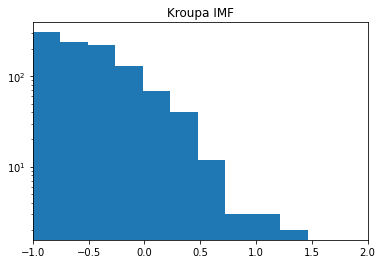

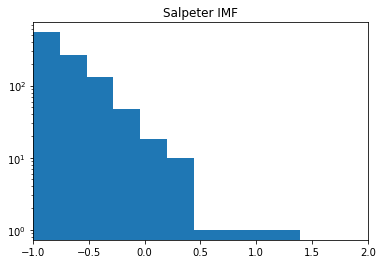

In [2]:
from amuse.datamodel import Particles
n_stars = 1024
mmin = 0.1 | units.MSun
mmax = 100 | units.MSun

from amuse.lab import new_kroupa_mass_distribution
mkroupa = new_kroupa_mass_distribution(n_stars,
                                           mass_min=mmin, 
                                           mass_max=mmax)
k_stars = Particles(mass=mkroupa)
from amuse.lab import new_salpeter_mass_distribution
msalpeter = new_salpeter_mass_distribution(n_stars, 
                                           mass_min=mmin, 
                                           mass_max=mmax)
s_stars = Particles(mass=msalpeter)
print("mean-mass for Kroupa=", numpy.mean(k_stars.mass))
print("mean-mass for Salpeter=", numpy.mean(s_stars.mass))

pyplot.hist(numpy.log10(k_stars.mass.value_in(units.MSun)))
pyplot.title('Kroupa IMF')
pyplot.yscale('log')
pyplot.xlim(-1, 2)
pyplot.figure()
pyplot.hist(numpy.log10(s_stars.mass.value_in(units.MSun)))
pyplot.title('Salpeter IMF')
pyplot.yscale('log')
pyplot.xlim(-1, 2)
pyplot.show()

Now that the mass functions are determined, we can evolve the stars in time. For this we start two stellar evolution codes, both parametrized, and evolve the stars in time.

In [3]:
from amuse.community.seba.interface import SeBa
def start_stellar_code(stars):
    stellar = SeBa()
    stellar.particles.add_particles(stars)
    channels = {"to_stars": stellar.particles.new_channel_to(stars), 
                "to_stellar": stars.new_channel_to(stellar.particles)}
    return stellar, channels
kstellar, kchannels = start_stellar_code(k_stars)
sstellar, schannels = start_stellar_code(s_stars)

Now the stellar evolution code are declared. Now evolve in time and calculate the mean mass as a function of time.

In [4]:
times = 10**numpy.arange(0.0, 4.0, 0.1) | units.Myr
mmean = []
for time in times:
    kstellar.evolve_model(time)
    kchannels["to_stars"].copy()
    sstellar.evolve_model(time)
    schannels["to_stars"].copy()
    mmean.append(numpy.mean(k_stars.mass)/numpy.mean(s_stars.mass))
kstellar.stop()
sstellar.stop()
print("mean-mass for Kroupa=", numpy.mean(k_stars.mass))
print("mean-mass for Salpeter=", numpy.mean(s_stars.mass))

mean-mass for Kroupa= 0.378059009987 MSun
mean-mass for Salpeter= 0.239818551176 MSun


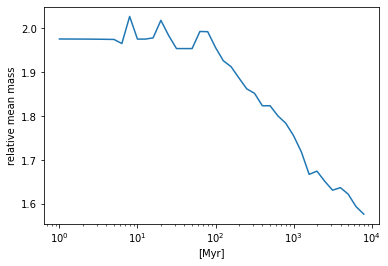

In [5]:
from amuse.plot import plot
plot(times, mmean)
pyplot.ylabel("relative mean mass")
pyplot.semilogx()
pyplot.show()

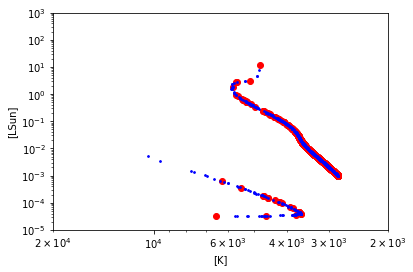

In [6]:
from amuse.plot import scatter
scatter(s_stars.temperature, s_stars.luminosity, c='r')
scatter(k_stars.temperature, k_stars.luminosity, c='b', s=3)
pyplot.xlim(2.e+4, 2000)
pyplot.ylim(1.e-5, 1000)
pyplot.loglog()
pyplot.show()

You have calculated the evolution of a stellar population with solar metalicity.

Assignments and questions:
---------------

### Assignment 1:
Run the notebook and describe the evolution of the relative mean stellar mass. Why does it drop with time?

### Assignment 2:
Compare the mean mass of two stellar populations with different metalicity, 0.002 (solar) and 0.01 (5 times solar) but the same stellar masses.

### Question 1:
Is there a difference in the number of compact objects (white dwarfs, neutron stars, black holes; these types are defined [here](https://github.com/amusecode/amuse/blob/main/src/amuse/units/units.py), and e.g. 1.|stellar_type corresponds to a main sequene star) in the populations with different initial mass functions, and with different metallicities, and is this difference statistically significant?

Is a similar difference also noticeable in the number of main sequence stars?

### Assignment 3:
Calculate, instead of the mean mass, the total luminosity and luminosity-weighted temperature ($T_{LW}=(\Sigma_iL_iT_i)/(\Sigma_iL_i)$, the effective color of the integrated stellar population) of the entire population of stars as a function of time.

Make a plot of these parameters for both mass functions, and both metallicities. 

### Question 4:
Can one, based on observational differences in luminosity and integrated temperature, make a distinction between the two mass functions?

#### Assignment 1
Over time the mass of the stars drops as a result of nuclear fusion or any other form of mass loss (stellar winds) during the main sequence phase. These processes lead to an energy output which causes the stars to bright and consequently loose mass (mass is equivalent to energy). 

#### Assignment 2

In [7]:
n_stars = 1024
mmin = 0.1 | units.MSun
mmax = 100 | units.MSun


mkroupa = new_kroupa_mass_distribution(n_stars,
                                           mass_min=mmin, 
                                           mass_max=mmax)
k_stars = Particles(mass=mkroupa)

msalpeter = new_salpeter_mass_distribution(n_stars, 
                                           mass_min=mmin, 
                                           mass_max=mmax)
s_stars = Particles(mass=msalpeter)
print("mean-mass for Kroupa=", numpy.mean(k_stars.mass))
print("mean-mass for Salpeter=", numpy.mean(s_stars.mass))

mean-mass for Kroupa= 0.758338617111 MSun
mean-mass for Salpeter= 0.371079245371 MSun


In [8]:
def start_stellar_code(stars, z):
    stellar = SeBa()
    stellar.parameters.metallicity = z
    stellar.particles.add_particles(stars)
    channels = {"to_stars": stellar.particles.new_channel_to(stars), 
                "to_stellar": stars.new_channel_to(stellar.particles)}
    return stellar, channels
z = 0.002
kstellar, kchannels = start_stellar_code(k_stars, z)
sstellar, schannels = start_stellar_code(s_stars, z)

In [9]:
times = 10**numpy.arange(0.0, 4.0, 0.1) | units.Myr
mmean = []
for time in times:
    kstellar.evolve_model(time)
    kchannels["to_stars"].copy()
    sstellar.evolve_model(time)
    schannels["to_stars"].copy()
    mmean.append(numpy.mean(k_stars.mass)/numpy.mean(s_stars.mass))
kstellar.stop()
sstellar.stop()
print("mean-mass for Kroupa=", numpy.mean(k_stars.mass))
print("mean-mass for Salpeter=", numpy.mean(s_stars.mass))

mean-mass for Kroupa= 0.424886649186 MSun
mean-mass for Salpeter= 0.258781233716 MSun


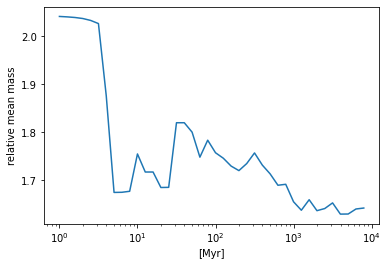

In [10]:
plot(times, mmean)
pyplot.ylabel("relative mean mass")
pyplot.semilogx()
pyplot.show()

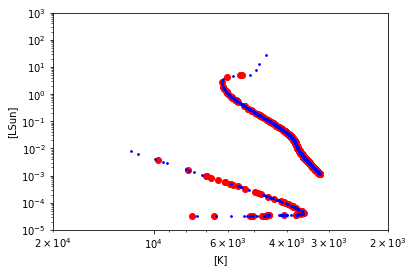

In [11]:
scatter(s_stars.temperature, s_stars.luminosity, c='r')
scatter(k_stars.temperature, k_stars.luminosity, c='b', s=3)
pyplot.xlim(2.e+4, 2000)
pyplot.ylim(1.e-5, 1000)
pyplot.loglog()
pyplot.show()

#### Question 1

In [12]:
wh = np.count_nonzero(k_stars.stellar_type == 10 | units.stellar_type)
wc = np.count_nonzero(k_stars.stellar_type == 11 | units.stellar_type)
wn = np.count_nonzero(k_stars.stellar_type == 12 | units.stellar_type)
print('Numbers of white dwarfs: ', wh + wc + wn)
n = np.count_nonzero(k_stars.stellar_type == 13 | units.stellar_type)
print('Numbers of neutron stars: ', n)
bh = np.count_nonzero(k_stars.stellar_type == 14 | units.stellar_type)
print('Numbers of black holes: ', bh)
ms = np.count_nonzero(k_stars.stellar_type == 1 | units.stellar_type)
print('Main-Sequence stars: ', ms)

Numbers of white dwarfs:  106
Numbers of neutron stars:  5
Numbers of black holes:  4
Main-Sequence stars:  905


#### Assignment 3

Calculate, instead of the mean mass, the total luminosity and luminosity-weighted temperature ($T_{LW}=(\Sigma_iL_iT_i)/(\Sigma_iL_i)$, the effective color of the integrated stellar population) of the entire population of stars as a function of time.

Make a plot of these parameters for both mass functions, and both metallicities. 



In [13]:
n_stars = 1024
mmin = 0.1 | units.MSun
mmax = 100 | units.MSun


mkroupa = new_kroupa_mass_distribution(n_stars,
                                           mass_min=mmin, 
                                           mass_max=mmax)
k_stars = Particles(mass=mkroupa)

msalpeter = new_salpeter_mass_distribution(n_stars, 
                                           mass_min=mmin, 
                                           mass_max=mmax)
s_stars = Particles(mass=msalpeter)
print("mean-mass for Kroupa=", numpy.mean(k_stars.mass))
print("mean-mass for Salpeter=", numpy.mean(s_stars.mass))



def start_stellar_code(stars, z):
    stellar = SeBa()
    stellar.parameters.metallicity = z
    stellar.particles.add_particles(stars)
    channels = {"to_stars": stellar.particles.new_channel_to(stars), 
                "to_stellar": stars.new_channel_to(stellar.particles)}
    return stellar, channels
z = 0.002
kstellar, kchannels = start_stellar_code(k_stars, z)
sstellar, schannels = start_stellar_code(s_stars, z)

ktemp = [] | units.K
klum = [] | units.LSun

stemp = [] | units.K
slum = [] | units.LSun


times = 10**numpy.arange(0.0, 4.0, 0.1) | units.Myr
mmean = []
for time in times:
    kstellar.evolve_model(time)
    kchannels["to_stars"].copy()
    sstellar.evolve_model(time)
    schannels["to_stars"].copy()
    mmean.append(numpy.mean(k_stars.mass)/numpy.mean(s_stars.mass))
    slum.append(s_stars.luminosity.sum())
    stemp.append((s_stars.luminosity * s_stars.temperature).sum() / s_stars.luminosity.sum())
    klum.append(k_stars.luminosity.sum())
    ktemp.append((k_stars.luminosity * k_stars.temperature).sum() / k_stars.luminosity.sum())
kstellar.stop()
sstellar.stop()
print("mean-mass for Kroupa=", numpy.mean(k_stars.mass))
print("mean-mass for Salpeter=", numpy.mean(s_stars.mass))

mean-mass for Kroupa= 0.531551625191 MSun
mean-mass for Salpeter= 0.300834078462 MSun
mean-mass for Kroupa= 0.346406088978 MSun
mean-mass for Salpeter= 0.240706746642 MSun


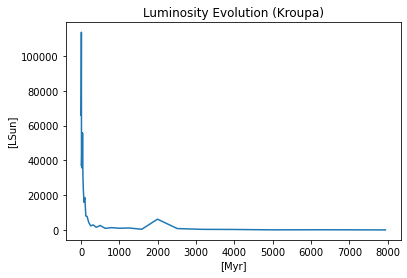

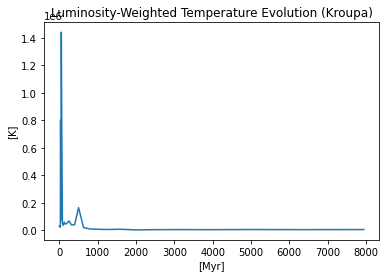

In [14]:
plot(times, klum)
pyplot.title('Luminosity Evolution (Kroupa)')
pyplot.show()
plot(times, ktemp)
pyplot.title('Luminosity-Weighted Temperature Evolution (Kroupa)')
pyplot.show()

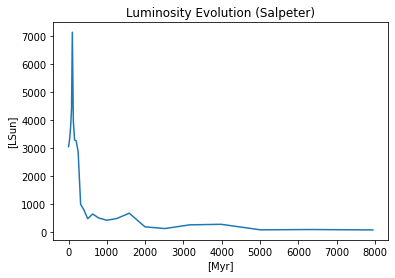

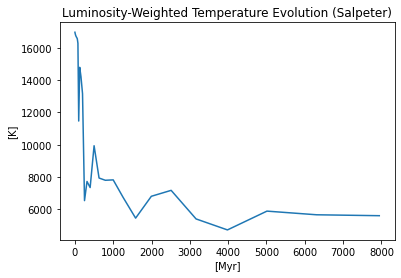

In [15]:
plot(times, slum)
pyplot.title('Luminosity Evolution (Salpeter)')
pyplot.show()
plot(times, stemp)
pyplot.title('Luminosity-Weighted Temperature Evolution (Salpeter)')
pyplot.show()